# 🍃 Durian Leaf Classifier Using Fine-Tuned ResNet-18

This project demonstrates how to fine-tune a pre-trained ResNet-18 convolutional neural network on a custom image dataset of durian leaves. The goal is to classify different types of durian leaves based on their visual appearance. The steps in this notebook cover:

- Dataset setup from a Kaggle leaf image dataset
- Data preprocessing and augmentation techniques
- Transfer learning with a pre-trained ResNet-18 model from PyTorch
- Fine-tuning the model using a custom training loop
- Model evaluation using accuracy and loss metrics
- Saving and exporting the model for deployment

This project serves as a practical showcase of:
- Image classification using deep learning
- Transfer learning with pretrained CNNs
- Best practices for training and validating deep models
- Real-world deployment readiness (ONNX + Docker + API)

Dataset used: [Durian Leaf Dataset on Kaggle](https://www.kaggle.com/datasets/dix2kurni/durian-leaf/data)

Author: Thomas Ian Budiman  
Date: May 2025

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change Working Directory

In [ ]:
import os

# Change to your desired path
os.chdir('/content/drive/MyDrive/Durian_Classifier_Project')

In [ ]:
# Verify the change
print("Current working directory:", os.getcwd())
!ls

Current working directory: /content/drive/MyDrive/Durian_Classifier_Project
best_resnet18_durian_leaf.pth  kaggle.json
Durian_Classifier.ipynb        resnet18_durian_leaf_1.pth
durian_leaf_data	       resnet18_durian_leaf_2.pth
durian-leaf.zip


## Download Dataset from Kaggle

This section handles authentication and downloading of the durian leaf dataset from [Kaggle](https://www.kaggle.com/datasets/dix2kurni/durian-leaf). It sets up the Kaggle API using your `kaggle.json` credentials, installs the required package, downloads the dataset, and extracts it for use.


The dataset contains **images of durian leaves from four different cultivars** commonly found in Southeast Asia:

* **Bawor**
* **Duri Hitam**
* **Musang King**
* **Super Tembaga**

Each image is labeled according to its cultivar, making this dataset suitable for supervised image classification tasks. The dataset is licensed under CC BY 4.0, allowing use with attribution.


In [ ]:
import os

# Create the ~/.kaggle directory
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Copy kaggle.json from Google Drive to ~/.kaggle
!cp /content/drive/MyDrive/Durian_Classifier_Project/kaggle.json ~/.kaggle/kaggle.json

# Set the appropriate permission
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 600)

# Install kaggle API (if not already installed)
!pip install -q kaggle

In [ ]:
# Download Durian Leaf dataset
!kaggle datasets download -d dix2kurni/durian-leaf

# Unzip it
import zipfile
with zipfile.ZipFile("durian-leaf.zip", "r") as zip_ref:
    zip_ref.extractall("durian_leaf_data")

Dataset URL: https://www.kaggle.com/datasets/dix2kurni/durian-leaf
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 317M/320M [00:02<00:00, 68.0MB/s]
100% 320M/320M [00:02<00:00, 125MB/s] 


In [ ]:
!ls durian_leaf_data

Bawor  DuriHitam  MusangKing  SuperTembaga


# Data

## Data Preprocessing

This section prepares the image data for training and validation. It applies a series of **data augmentation techniques** (e.g., random crops, flips, rotations, and lighting changes) to artificially increase training data diversity and improve model generalization. All images are resized to **224×224 pixels** and normalized using **ImageNet's mean and standard deviation** to match the input expectations of the pre-trained ResNet-18 model.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transforms for preprocessing
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to ResNet input size
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet mean
#                          [0.229, 0.224, 0.225])   # Imagenet std
# ])
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),     # random zoom
    transforms.RandomHorizontalFlip(p=0.5),                  # mirror image
    transforms.RandomRotation(20),                           # ±20° rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3),    # lighting variation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),# slight shift
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder('durian_leaf_data', transform=None)
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['Bawor', 'DuriHitam', 'MusangKing', 'SuperTembaga']


## Data Split and Load

This section splits the dataset into **80% training and 20% validation** subsets using `random_split`. Appropriate image transformations (augmentations for training, basic resizing for validation) are applied to each subset. The resulting datasets are then wrapped in PyTorch `DataLoader` objects to enable efficient batch loading during training and evaluation.


In [ ]:
# 80% train, 20% validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) -D train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Manually assign transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model: ResNet18

## Load Model

This section loads the pre-trained **ResNet-18** model with weights trained on the ImageNet dataset. To leverage transfer learning effectively while adapting the model to the durian leaf classification task:

* **All layers are initially frozen** to retain pre-learned low-level features.
* Then, **`layer3`, `layer4`, and the final fully connected (fc) layer** are **selectively unfrozen**. These deeper layers learn more complex, high-level representations, which are more relevant to the target task.
* The **fully connected layer is replaced** to match the number of durian classes.
* Finally, the model is moved to GPU (if available) for faster training.

This fine-tuning strategy allows the model to adapt without overfitting, especially when the training dataset is relatively small.



In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights

# Load model with pretrained ImageNet weights
weights = ResNet18_Weights.DEFAULT  # or .IMAGENET1K_V1 if you want to be specific
model = resnet18(weights=weights)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-18 model
# model = models.resnet18(pretrained=True)

# Freeze all layers except the final one
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer3, layer4, and fc
for name, param in model.named_parameters():
    if 'layer4' in name or 'layer3' in name or 'fc' in name:
        param.requires_grad = True

# Replace the final fully connected layer
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU (if available)
model = model.to(device)

## Loss Function & Optimizer

This section defines the core components required for training:

* **Loss Function**: `CrossEntropyLoss()` is used since this is a multi-class classification problem. It measures the difference between predicted class probabilities and the true labels.
* **Optimizer**: `Adam` is used with a **low learning rate (`1e-4`)**, suitable for fine-tuning a pre-trained model. Only parameters with `requires_grad=True` (i.e., `layer3`, `layer4`, and `fc`) are updated.
* **Learning Rate Scheduler**: `ReduceLROnPlateau` automatically reduces the learning rate if validation performance plateaus, helping the model converge better and avoid local minima.

This setup balances training speed and stability, especially important when adapting a large pre-trained model to a smaller, custom dataset.

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4  # Use a lower LR for fine-tuning
)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

## Early Stopping

This section implements a custom `EarlyStopping` mechanism to halt training when the validation loss **no longer improves for a set number of epochs** (controlled by the `patience` parameter). This helps:

* Prevent overfitting on the training data.
* Save time and computational resources by stopping training early.

The class tracks the best validation loss and increases a counter each time the loss fails to improve. When the counter exceeds the patience threshold, training can be terminated.


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
early_stopper = EarlyStopping(patience=5)

## Training Loop

This section implements the full training process over a specified number of epochs. It includes:

* **Training Phase**:

  * The model is set to training mode.
  * For each batch, it computes predictions, calculates loss, performs backpropagation, and updates model weights.
  * It also tracks running loss and accuracy for performance logging.

* **Validation Phase**:

  * The model is switched to evaluation mode and gradients are disabled.
  * It computes the validation loss and accuracy to monitor generalization.

* **Model Checkpointing**:

  * Saves the model weights when validation loss improves.

* **Learning Rate Scheduling**:

  * `ReduceLROnPlateau` adjusts learning rate dynamically based on validation loss plateau.

* **Early Stopping**:

  * Training stops early if validation loss fails to improve for a specified number of epochs.

The loop also uses `tqdm` for real-time progress bars and provides helpful logging at each epoch, including current loss, accuracy, and learning rate.

In [ ]:
!pip install -q tqdm
from tqdm import tqdm

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
best_model_path = 'best_resnet18_durian_leaf.pth'

num_epochs = 15

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # ---- Training ----
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    train_losses.append(train_loss / train_total)
    train_accuracies.append(train_correct / train_total)

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    loop = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item())

    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total)

    print(f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracies[-1]:.4f}")

    # Save best model if val loss improves
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved (val_loss = {best_val_loss:.4f})")

    # Activate LR Scheduler (if needed), based on val loss. Print current LR
    scheduler.step(val_losses[-1])
    early_stopper(val_losses[-1])

    for param_group in optimizer.param_groups:
        print(f"Epoch {epoch+1} - Current LR: {param_group['lr']:.6f}")

    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break


Epoch 1/15


Train Loss: 0.5503, Acc: 0.8137
Val Loss: 0.2337, Acc: 0.9150
✅ Best model saved (val_loss = 0.2337)
Epoch 1 - Current LR: 0.000100

Epoch 2/15


Train Loss: 0.0584, Acc: 0.9902
Val Loss: 0.1022, Acc: 0.9706
✅ Best model saved (val_loss = 0.1022)
Epoch 2 - Current LR: 0.000100

Epoch 3/15


Train Loss: 0.0177, Acc: 1.0000
Val Loss: 0.0770, Acc: 0.9706
✅ Best model saved (val_loss = 0.0770)
Epoch 3 - Current LR: 0.000100

Epoch 4/15


Train Loss: 0.0072, Acc: 1.0000
Val Loss: 0.0650, Acc: 0.9706
✅ Best model saved (val_loss = 0.0650)
Epoch 4 - Current LR: 0.000100

Epoch 5/15


Train Loss: 0.0080, Acc: 1.0000
Val Loss: 0.0623, Acc: 0.9837
✅ Best model saved (val_loss = 0.0623)
Epoch 5 - Current LR: 0.000100

Epoch 6/15


Train Loss: 0.0046, Acc: 1.0000
Val Loss: 0.0575, Acc: 0.9804
✅ Best model saved (val_loss = 0.0575)
Epoch 6 - Current LR: 0.000100

Epoch 7/15


Train Loss: 0.0036, Acc: 1.0000
Val Loss: 0.0787, Acc: 0.9641
🛑 EarlyStopping counter: 1/5
Epoch 7 - Current LR: 0.000100

Epoch 8/15


Train Loss: 0.0091, Acc: 0.9984
Val Loss: 0.0892, Acc: 0.9673
🛑 EarlyStopping counter: 2/5
Epoch 8 - Current LR: 0.000100

Epoch 9/15


Train Loss: 0.0115, Acc: 0.9967
Val Loss: 0.0744, Acc: 0.9739
🛑 EarlyStopping counter: 3/5
Epoch 9 - Current LR: 0.000050

Epoch 10/15


Train Loss: 0.0087, Acc: 0.9984
Val Loss: 0.0625, Acc: 0.9771
🛑 EarlyStopping counter: 4/5
Epoch 10 - Current LR: 0.000050

Epoch 11/15


Train Loss: 0.0061, Acc: 0.9992
Val Loss: 0.0635, Acc: 0.9771
🛑 EarlyStopping counter: 5/5
Epoch 11 - Current LR: 0.000050
Early stopping triggered.


## Results

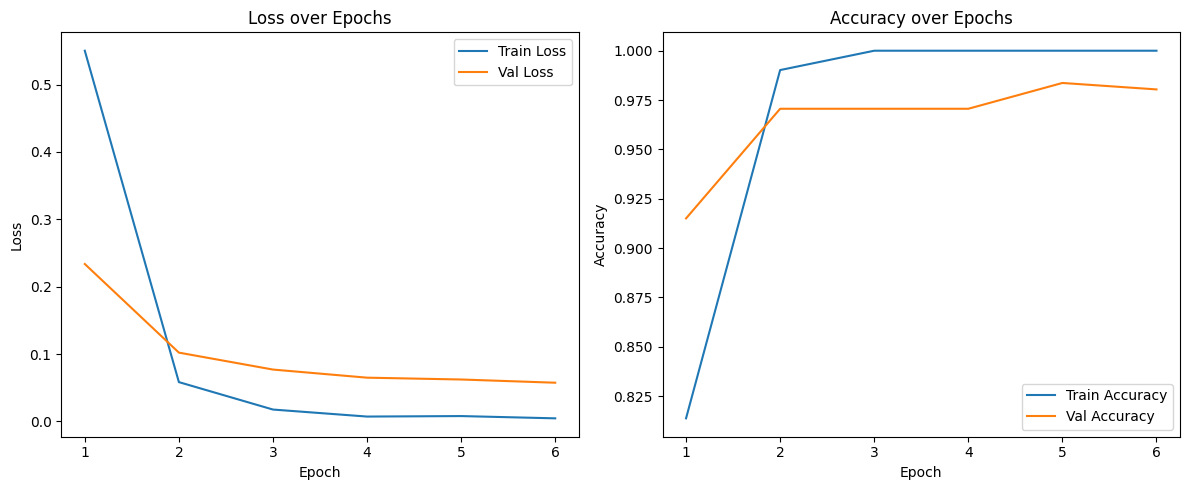

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs[:6], train_losses[:6], label="Train Loss")
plt.plot(epochs[:6], val_losses[:6], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs[:6], train_accuracies[:6], label="Train Accuracy")
plt.plot(epochs[:6], val_accuracies[:6], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


### 📊 **Results & Analysis**

The training and validation performance over the first 6 epochs are visualized above.

#### 🔻 Loss Trends:

* **Training loss** consistently decreased, dropping rapidly in the first few epochs and approaching zero by epoch 6.
* **Validation loss** followed a similar downward trend, showing steady improvement and **no significant divergence**, indicating that the model generalizes well and is not overfitting within this window.

#### 📈 Accuracy Trends:

* **Training accuracy** quickly climbed and plateaued near **100%**, demonstrating that the model learned to classify the training data almost perfectly.
* **Validation accuracy** also reached above **97%** early on and remained stable, showing strong generalization to unseen data.

#### 🧠 Interpretation:

* The sharp initial improvement followed by a plateau suggests that the model benefited significantly from **transfer learning**, using the pre-trained ResNet-18 as a strong feature extractor.
* The combination of **data augmentation**, **selective fine-tuning (layer3, layer4, fc)**, and a **low learning rate** helped achieve high performance without overfitting.
* Based on the validation loss curve, performance might improve slightly with continued training, but gains would likely be marginal — especially since **early stopping** was used to prevent overtraining.

# Test

## Load Model

In [ ]:
model.load_state_dict(torch.load('best_resnet18_durian_leaf.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Load Test Image

This section demonstrates how to perform **inference** using the fine-tuned ResNet-18 model:

* A test image is loaded using `PIL`, resized to match the model's expected input (224×224), normalized using ImageNet statistics, and converted into a tensor with a batch dimension.
* The model then performs forward inference in evaluation mode (`no_grad()`), and the class with the highest predicted probability is returned as the output.
* Finally, the predicted durian leaf type is printed.

This section validates the model’s deployment readiness and provides a simple example for running predictions on new input data.

In [ ]:
# Define transforms for preprocessing
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Imagenet mean
                         [0.229, 0.224, 0.225])   # Imagenet std
])

🔍 Predicted Leaf Type: Bawor


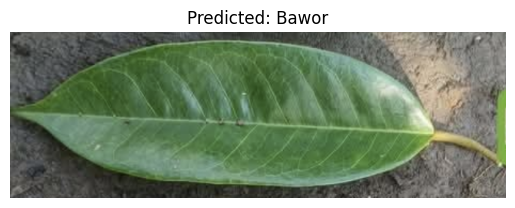

In [ ]:
from PIL import Image

# Load image
# img_path = "/content/duri_hitam2.png"
# img_path = "/content/musang_king2.png"
img_path = "/content/bawor.png"
image = Image.open(img_path).convert('RGB')

# Transform and add batch dimension
input_tensor = inference_transform(image).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = class_names[output.argmax().item()]

print(f"🔍 Predicted Leaf Type: {predicted_class}")

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

## Download Model
This section allows the trained model to be downloaded from the Colab environment to your local machine. The model is saved in `.pth` format (PyTorch's native checkpoint format), which can be used later for inference or further fine-tuning.


In [ ]:
from google.colab import files
files.download("best_resnet18_durian_leaf.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ONNX

This section converts the trained PyTorch model into the **ONNX (Open Neural Network Exchange)** format. ONNX is an open standard supported by many inference engines, making the model portable across different platforms and frameworks (e.g., TensorRT, OpenVINO, web apps).

Steps included:

* Load and prepare the fine-tuned ResNet-18 model.
* Provide a **dummy input** for tracing the model architecture.
* Export the model to `durian_classifier.onnx` with batch-size flexibility (`dynamic_axes`).
* Download the ONNX file for deployment.

✅ This makes your model deployment-ready for various environments like servers, edge devices, or web apps.

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 118.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class_names = ['Bawor', 'DuriHitam', 'MusangKing', 'SuperTembaga']

# Load model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("best_resnet18_durian_leaf.pth", map_location=torch.device('cpu')))
model.eval()

# Dummy input for tracing
dummy_input = torch.randn(1, 3, 224, 224)

# Export to ONNX
torch.onnx.export(
    model,
    dummy_input,
    "durian_classifier.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

print("✅ ONNX model exported.")

✅ ONNX model exported.


In [ ]:
from google.colab import files
files.download("durian_classifier.onnx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>